In [1]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
import scipy as scipy

# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
import dask
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="03:00:00",
    account="P93300041",
    memory="4GB",
    resource_spec="select=1:ncpus=1:mem=4GB",
    cores=1,
    processes=1,
)

from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

cluster.scale(8)
client.wait_for_workers(8)


In [4]:
client

<Client: 'tcp://128.117.208.188:39785' processes=0 threads=0, memory=0 B>

In [3]:
# # Scheduler address from the launch_cluster notebook.
# from dask.distributed import Client

# client = Client("tcp://128.117.208.103:44091")

## Read in ensembles


In [5]:
%%time
ctrlDirs = np.sort(glob.glob('/glade/derecho/scratch/ssfcst/archive/cesm2cam6_noahMP_2021-06-01.*'))
dryDirs  = np.sort(glob.glob('/glade/derecho/scratch/ssfcst/archive/cesm2cam6_noahMP_lowSM_2021-06-01.*'))
wetDirs  = np.sort(glob.glob('/glade/derecho/scratch/ssfcst/archive/cesm2cam6_noahMP_highSM_2021-06-01.*'))

for iEns in range(11): 
    keepVars = ['SOILWATER_10CM']
    keepVarsAtm = ['TREFHT','LHFLX','SHFLX','PRECT']
    
    ## Get DS in CTRL
    DS_lnd_ctrl_ens = xr.open_dataset(np.sort(glob.glob(ctrlDirs[iEns]+'/lnd/hist/*'))[0])
    DS_lnd_ctrl_ens = DS_lnd_ctrl_ens.assign_coords({"ens":  iEns})
    DS_atm_ctrl_ens = xr.open_dataset(np.sort(glob.glob(ctrlDirs[iEns]+'/atm/hist/*h2*'))[0])
    DS_atm_ctrl_ens = DS_atm_ctrl_ens.assign_coords({"ens":  iEns})
    if iEns==0:
        lndDS_ctrl = DS_lnd_ctrl_ens[keepVars]
        atmDS_ctrl = DS_atm_ctrl_ens[keepVarsAtm]
    else:
        lndDS_ctrl = xr.concat([lndDS_ctrl, DS_lnd_ctrl_ens[keepVars]], "ens")
        atmDS_ctrl = xr.concat([atmDS_ctrl, DS_atm_ctrl_ens[keepVarsAtm]], "ens")
    
    ## Get land DS in Dry
    DS_lnd_dry_ens = xr.open_dataset(np.sort(glob.glob(dryDirs[iEns]+'/lnd/hist/*'))[0])
    DS_lnd_dry_ens = DS_lnd_dry_ens.assign_coords({"ens":  iEns})
    DS_atm_dry_ens = xr.open_dataset(np.sort(glob.glob(dryDirs[iEns]+'/atm/hist/*h2*'))[0])
    DS_atm_dry_ens = DS_atm_dry_ens.assign_coords({"ens":  iEns})
    if iEns==0:
        lndDS_dry = DS_lnd_dry_ens[keepVars]
        atmDS_dry = DS_atm_dry_ens[keepVarsAtm]
    else:
        lndDS_dry = xr.concat([lndDS_dry, DS_lnd_dry_ens[keepVars]], "ens")
        atmDS_dry = xr.concat([atmDS_dry, DS_atm_dry_ens[keepVarsAtm]], "ens")

    ## Get land DS in Wet
    DS_lnd_wet_ens = xr.open_dataset(np.sort(glob.glob(wetDirs[iEns]+'/lnd/hist/*'))[0])
    DS_lnd_wet_ens = DS_lnd_wet_ens.assign_coords({"ens":  iEns})
    DS_atm_wet_ens = xr.open_dataset(np.sort(glob.glob(wetDirs[iEns]+'/atm/hist/*h2*'))[0])
    DS_atm_wet_ens = DS_atm_wet_ens.assign_coords({"ens":  iEns})
    if iEns==0:
        lndDS_wet = DS_lnd_wet_ens[keepVars]
        atmDS_wet = DS_atm_wet_ens[keepVarsAtm]
    else:
        lndDS_wet = xr.concat([lndDS_wet, DS_lnd_wet_ens[keepVars]], "ens")
        atmDS_wet = xr.concat([atmDS_wet, DS_atm_wet_ens[keepVarsAtm]], "ens")



CPU times: user 4.52 s, sys: 14.6 s, total: 19.1 s
Wall time: 1min 1s


## Initial analysis?

In [14]:
atmDS_ctrl['TREFHT_degC'] = atmDS_ctrl['TREFHT'] - 273.15
atmDS_dry['TREFHT_degC']  = atmDS_dry['TREFHT'] - 273.15
atmDS_wet['TREFHT_degC']  = atmDS_wet['TREFHT'] - 273.15


atmDS_ctrl['PRECT_mmd'] = atmDS_ctrl['PRECT'] * 1000 * 86400
atmDS_dry['PRECT_mmd']  = atmDS_dry['PRECT']  * 1000 * 86400
atmDS_wet['PRECT_mmd']  = atmDS_wet['PRECT']  * 1000 * 86400



In [15]:
lndDS_ctrl_ensMean = lndDS_ctrl.mean(dim='ens')
lndDS_dry_ensMean  = lndDS_dry.mean(dim='ens')
lndDS_wet_ensMean  = lndDS_wet.mean(dim='ens')

atmDS_ctrl_ensMean = atmDS_ctrl.mean(dim='ens')
atmDS_dry_ensMean  = atmDS_dry.mean(dim='ens')
atmDS_wet_ensMean  = atmDS_wet.mean(dim='ens')


In [12]:
landMask = np.full([len(lndDS_ctrl.lat.values), len(lndDS_ctrl.lon.values)], np.nan)
landMask[np.isfinite(lndDS_ctrl_ensMean.SOILWATER_10CM.isel(time=1).values)==True] = 1

# plt.contourf(landMask)
# plt.colorbar()

In [7]:
## A few plot options that are a bit more generic 
longrid, latgrid = np.meshgrid(lndDS_ctrl['lon'], lndDS_ctrl['lat'] )
normVar = matplotlib.colors.Normalize(vmin=0, vmax=60)


[None, None, None, None, None, None, None, None, None]

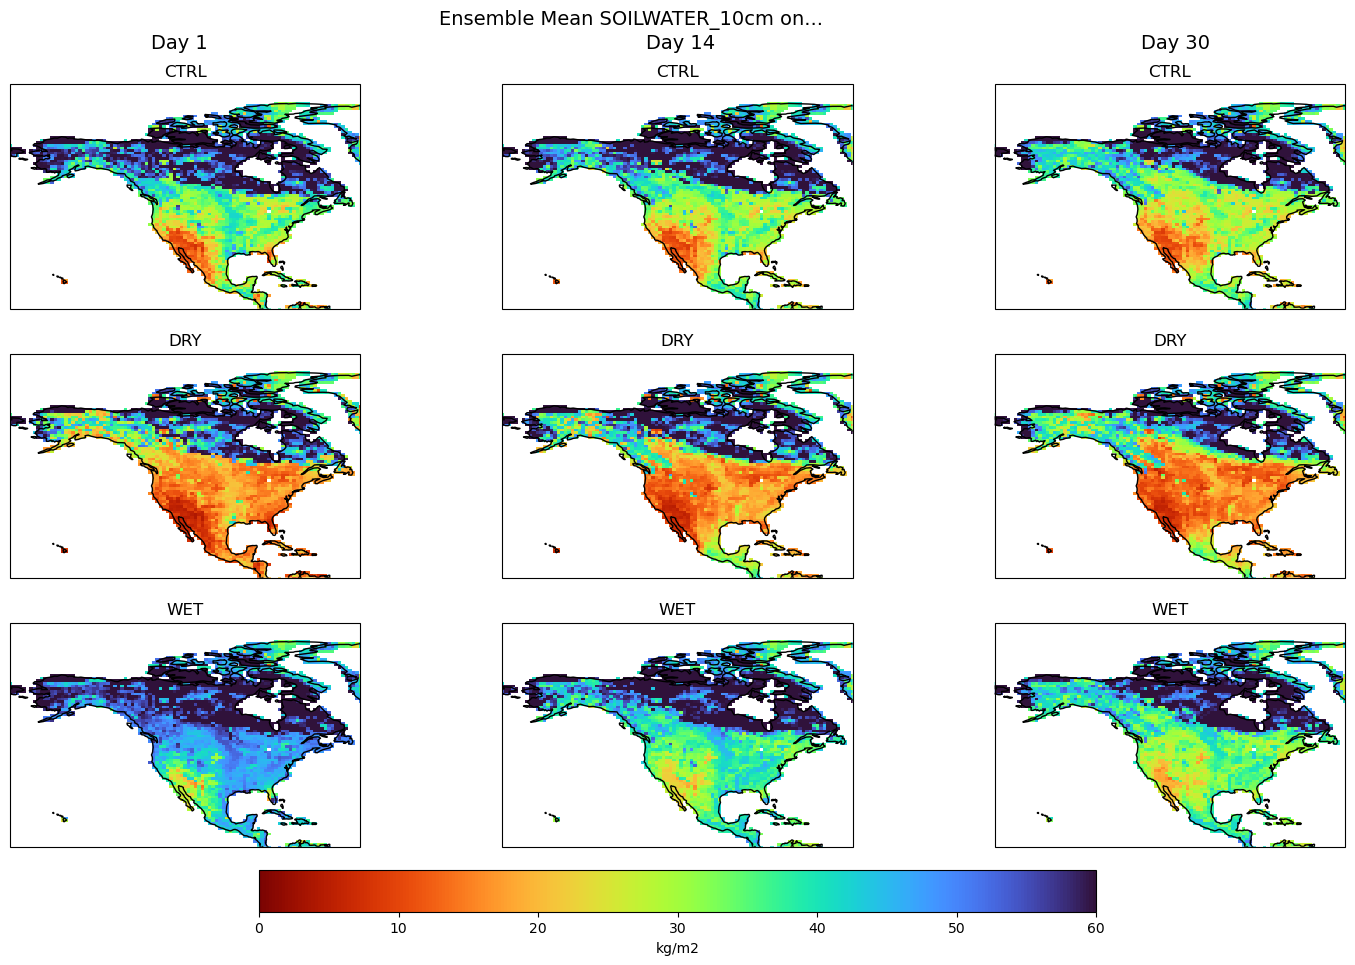

In [9]:
timesSel = [1,14,30]

fig,axs = plt.subplots(3,3, figsize=(18,12),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()
fig.text(0.38,0.93,'Ensemble Mean SOILWATER_10cm on... ',fontsize=14)

for iTimes in range(len(timesSel)): 
    iselTime = timesSel[iTimes]

    axs[iTimes].pcolormesh(longrid,latgrid, lndDS_ctrl_ensMean.SOILWATER_10CM.isel(time=iselTime).values, 
                  cmap='turbo_r', norm=normVar, transform=ccrs.PlateCarree())
    axs[(iTimes)+3].pcolormesh(longrid,latgrid, lndDS_dry_ensMean.SOILWATER_10CM.isel(time=iselTime).values,
                      cmap='turbo_r', norm=normVar, transform=ccrs.PlateCarree())
    p = axs[(iTimes)+6].pcolormesh(longrid,latgrid, lndDS_wet_ensMean.SOILWATER_10CM.isel(time=iselTime).values, 
                          cmap='turbo_r', norm=normVar, transform=ccrs.PlateCarree())
    
    fig.text(0.22+(iTimes*0.275),0.91,'Day '+str(iselTime),fontsize=14)
    
    axs[(iTimes)+0].set_title('CTRL')
    axs[(iTimes)+3].set_title('DRY')
    axs[(iTimes)+6].set_title('WET') 
    
cb = fig.colorbar(p, ax=axs, shrink=0.6, label=lndDS_ctrl.SOILWATER_10CM.units, orientation='horizontal', pad=0.025) 

[a.coastlines() for a in axs]
# [a.set_extent([-180,180,-60,90]) for a in axs]
[a.set_extent([185,310,10,90]) for a in axs]


# [a.coastlines() for a in axs]
# [a.set_extent([185,310,10,90]) for a in axs]


**Look at prect too?**

In [33]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')


[None, None, None, None, None, None, None, None, None]

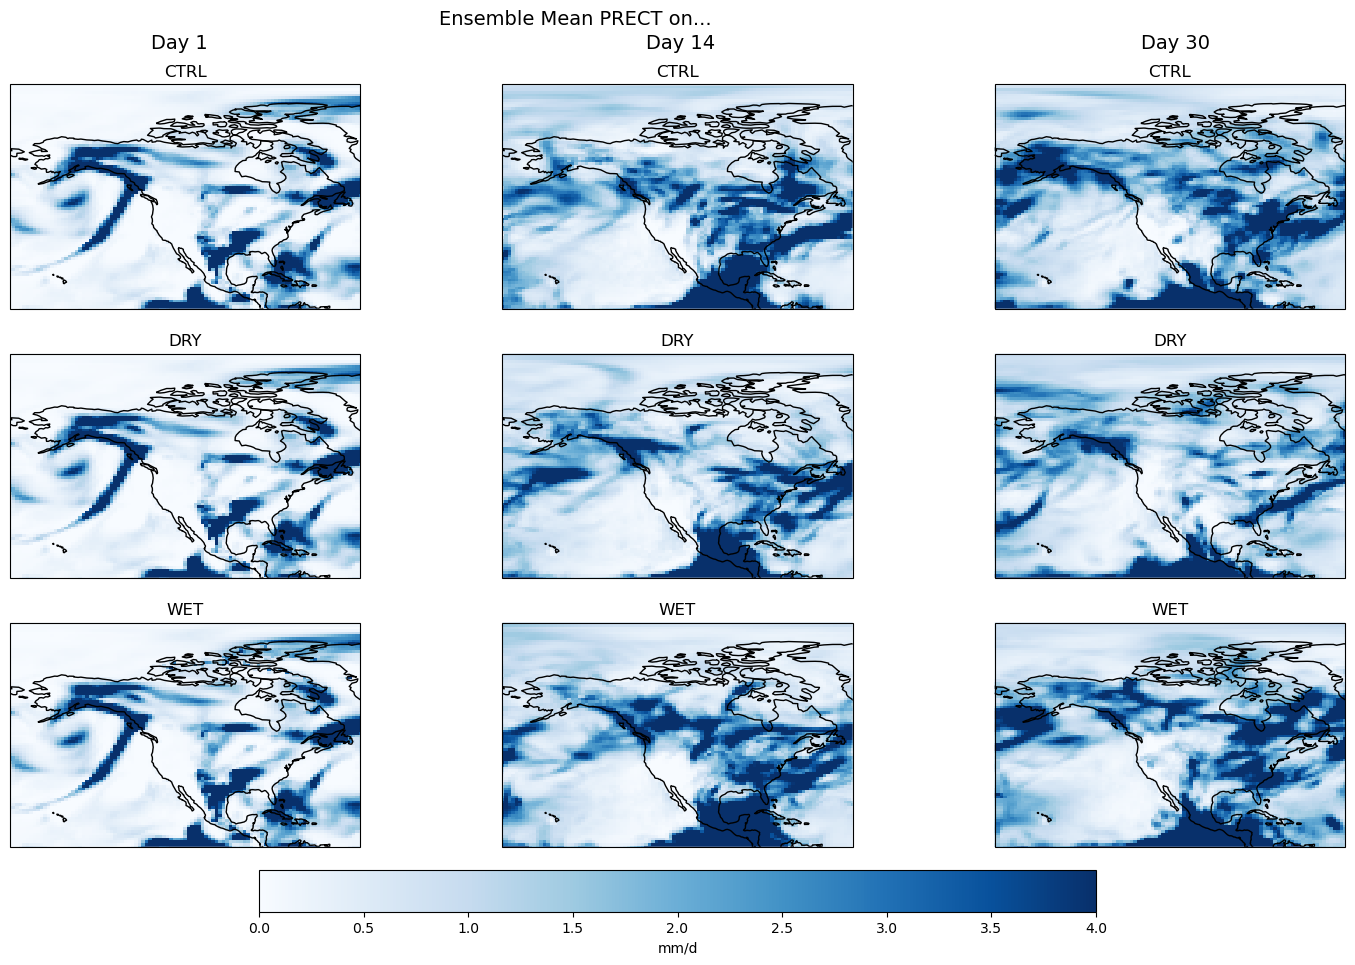

In [20]:
## A few plot options that are a bit more generic 
longrid, latgrid = np.meshgrid(lndDS_ctrl['lon'], lndDS_ctrl['lat'] )
normVar = matplotlib.colors.Normalize(vmin=0, vmax=4)

timesSel = [1,14,30]

fig,axs = plt.subplots(3,3, figsize=(18,12),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()
fig.text(0.38,0.93,'Ensemble Mean PRECT on... ',fontsize=14)

for iTimes in range(len(timesSel)): 
    iselTime = timesSel[iTimes]

    axs[iTimes].pcolormesh(longrid,latgrid, atmDS_ctrl_ensMean.PRECT_mmd.isel(time=iselTime).values, 
                  cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
    axs[(iTimes)+3].pcolormesh(longrid,latgrid, atmDS_dry_ensMean.PRECT_mmd.isel(time=iselTime).values,
                      cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
    p = axs[(iTimes)+6].pcolormesh(longrid,latgrid, atmDS_wet_ensMean.PRECT_mmd.isel(time=iselTime).values, 
                          cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
    
    fig.text(0.22+(iTimes*0.275),0.91,'Day '+str(iselTime),fontsize=14)
    
    axs[(iTimes)+0].set_title('CTRL')
    axs[(iTimes)+3].set_title('DRY')
    axs[(iTimes)+6].set_title('WET') 
    
cb = fig.colorbar(p, ax=axs, shrink=0.6, label='mm/d', orientation='horizontal', pad=0.025) 

[a.coastlines() for a in axs]
# [a.set_extent([-180,180,-60,90]) for a in axs]
[a.set_extent([185,310,10,90]) for a in axs]


# [a.coastlines() for a in axs]
# [a.set_extent([185,310,10,90]) for a in axs]



In [27]:
## Get week means and differences? 

week1_ctrl = atmDS_ctrl_ensMean.isel(time=np.arange(7)).mean(dim='time')
week2_ctrl = atmDS_ctrl_ensMean.isel(time=np.arange(7)+7).mean(dim='time')
week3_ctrl = atmDS_ctrl_ensMean.isel(time=np.arange(7)+14).mean(dim='time')

week1_dry = atmDS_dry_ensMean.isel(time=np.arange(7)).mean(dim='time')
week2_dry = atmDS_dry_ensMean.isel(time=np.arange(7)+7).mean(dim='time')
week3_dry = atmDS_dry_ensMean.isel(time=np.arange(7)+14).mean(dim='time')

week1_wet = atmDS_wet_ensMean.isel(time=np.arange(7)).mean(dim='time')
week2_wet = atmDS_wet_ensMean.isel(time=np.arange(7)+7).mean(dim='time')
week3_wet = atmDS_wet_ensMean.isel(time=np.arange(7)+14).mean(dim='time')


In [84]:
week1_diff = atmDS_wet.PRECT_mmd.isel(time=np.arange(7)).mean(dim='time') - atmDS_dry.PRECT_mmd.isel(time=np.arange(7)).mean(dim='time')


In [91]:
wet = atmDS_wet.PRECT_mmd.isel(time=np.arange(7)).mean(dim='time')
dry = atmDS_dry.PRECT_mmd.isel(time=np.arange(7)).mean(dim='time')
t_week1 = scipy.stats.ttest_rel(wet,dry,axis=0)

In [97]:
# np.shape(t_week1.pvalue)
pVal = t_week1.pvalue
# pVal[pVal>0.05] = np.nan
np.shape(pVal)

(192, 288)

In [102]:
atmDS_wet.PRECT_mmd.isel(time=np.arange(7)).mean(dim='time')

<xarray.DataArray 'PRECT_mmd' (ens: 11, lat: 192, lon: 288)> Size: 5MB
array([[[0.22232739, 0.22232739, 0.22232739, ..., 0.22232739,
         0.22232739, 0.22232739],
        [0.0541764 , 0.05262892, 0.05112822, ..., 0.05953793,
         0.05773962, 0.05586624],
        [0.0092489 , 0.00926293, 0.00953331, ..., 0.00907639,
         0.00915979, 0.00918553],
        ...,
        [0.32466518, 0.31782769, 0.31165789, ..., 0.33206927,
         0.33049276, 0.32792337],
        [0.42440654, 0.41621523, 0.40798416, ..., 0.44077558,
         0.44098801, 0.4369459 ],
        [0.59690785, 0.59684337, 0.59678476, ..., 0.59713519,
         0.59705154, 0.59697842]],

       [[0.02023231, 0.02023231, 0.02023231, ..., 0.02023231,
         0.02023231, 0.02023231],
        [0.00471311, 0.00468072, 0.00465501, ..., 0.00482571,
         0.00478567, 0.00474713],
        [0.00379687, 0.00380745, 0.00377647, ..., 0.00383913,
         0.00377706, 0.00374161],
...
        [0.51918731, 0.51382336, 0.50934747, ..., 0.52871612,
         0.52778605, 0.52458669],
        [0.41527511, 0.40351071, 0.3941836 , ..., 0.44106746,
         0.43650613, 0.42738141],
        [0.32594357, 0.32592735, 0.32591275, ..., 0.32600322,
         0.32598141, 0.32596145]],

       [[0.08569069, 0.08569069, 0.08569069, ..., 0.08569069,
         0.08569069, 0.08569069],
        [0.01560141, 0.0154219 , 0.01528316, ..., 0.01632582,
         0.01605437, 0.01581955],
        [0.00284676, 0.00289961, 0.00291772, ..., 0.00271193,
         0.00271818, 0.0027718 ],
        ...,
        [0.22638416, 0.22641492, 0.22671137, ..., 0.22869124,
         0.22749843, 0.22618239],
        [0.20298854, 0.20696626, 0.20663543, ..., 0.22124188,
         0.21587444, 0.20678084],
        [0.20450288, 0.20445836, 0.20442146, ..., 0.20465592,
         0.20459734, 0.20454775]]])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * ens      (ens) int64 88B 0 1 2 3 4 5 6 7 8 9 10

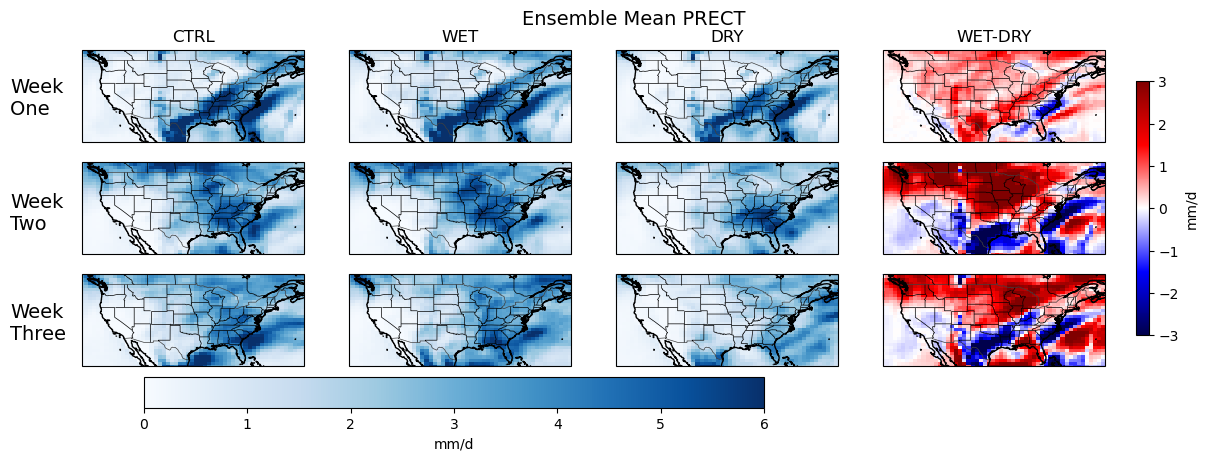

In [104]:
## Plot by week 
normVar = matplotlib.colors.Normalize(vmin=0, vmax=6)
diffVar = matplotlib.colors.Normalize(vmin=-3, vmax=3)

fig,axs = plt.subplots(3,4, figsize=(16,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]
[a.coastlines() for a in axs]
[a.set_extent([230,298,24,47]) for a in axs]

fig.text(0.4,0.93,'Ensemble Mean PRECT ',fontsize=14)
fig.text(0.08,0.75,'Week\nOne ',fontsize=14)
fig.text(0.08,0.52,'Week\nTwo ',fontsize=14)
fig.text(0.08,0.3,'Week\nThree ',fontsize=14)

axs[0].set_title('CTRL')
axs[1].set_title('WET')
axs[2].set_title('DRY')
axs[3].set_title('WET-DRY')

## Week 1
axs[0].pcolormesh(longrid,latgrid, week1_ctrl.PRECT_mmd.values, cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs[1].pcolormesh(longrid,latgrid, week1_wet.PRECT_mmd.values, cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs[2].pcolormesh(longrid,latgrid, week1_dry.PRECT_mmd.values, cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs[3].pcolormesh(longrid,latgrid, week1_wet.PRECT_mmd.values - week1_dry.PRECT_mmd.values, cmap='seismic', norm=diffVar, transform=ccrs.PlateCarree())

# t_week1 = scipy.stats.ttest_rel(atmDS_wet.PRECT_mmd.isel(time=np.arange(7)).mean(dim='time'),
#                                 atmDS_dry.PRECT_mmd.isel(time=np.arange(7)).mean(dim='time'),
#                                 axis=0) # Along ens dimension
# pVal = t_week1.pvalue
# for iLon in range(len(week1_wet.lon.values)):
#     for iLat in range(len(week1_wet.lat.values)): 
#         if pVal[iLat,iLon]<=0.05:
#             axs[3].plot(week1_wet.lon.values[iLon], week1_wet.lat.values[iLat], 'k.', markersize=0.5, transform=ccrs.PlateCarree())
        
## Week 2
axs[4].pcolormesh(longrid,latgrid, week2_ctrl.PRECT_mmd.values, cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs[5].pcolormesh(longrid,latgrid, week2_wet.PRECT_mmd.values, cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs[6].pcolormesh(longrid,latgrid, week2_dry.PRECT_mmd.values, cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
axs[7].pcolormesh(longrid,latgrid, week2_wet.PRECT_mmd.values - week1_dry.PRECT_mmd.values, cmap='seismic', norm=diffVar, transform=ccrs.PlateCarree())

## Week 1
axs[8].pcolormesh(longrid,latgrid, week3_ctrl.PRECT_mmd.values, cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
c1=axs[9].pcolormesh(longrid,latgrid, week3_wet.PRECT_mmd.values, cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
fig.colorbar(c1, ax=axs, shrink=0.5, label='mm/d', orientation='horizontal', anchor=(0.1,1), pad=0.025) 

axs[10].pcolormesh(longrid,latgrid, week3_dry.PRECT_mmd.values, cmap='Blues', norm=normVar, transform=ccrs.PlateCarree())
c2=axs[11].pcolormesh(longrid,latgrid, week3_wet.PRECT_mmd.values - week1_dry.PRECT_mmd.values, cmap='seismic', norm=diffVar, transform=ccrs.PlateCarree())

fig.colorbar(c2, ax=axs, shrink=0.8, label='mm/d', orientation='vertical', pad=0.025) 



In [105]:
def plot_NAm_timeseries(DS_ctrl, DS_dry, DS_wet, varSel):
    ## Narrow in on N America? 
    ctrl_NAm = (landMask* DS_ctrl[varSel]).sel(lat=slice(10,75), lon=slice(187.5,312.5))
    dry_NAm  = (landMask* DS_dry[varSel]).sel(lat=slice(10,75), lon=slice(187.5,312.5))
    wet_NAm  = (landMask* DS_wet[varSel]).sel(lat=slice(10,75), lon=slice(187.5,312.5))

    coswgt   = np.cos(np.deg2rad(DS_ctrl.lat))

    ctrl_NAm_mean   = ctrl_NAm.weighted(coswgt).mean(('lon','lat'))
    dry_NAm_mean    = dry_NAm.weighted(coswgt).mean(('lon','lat'))
    wet_NAm_mean    = wet_NAm.weighted(coswgt).mean(('lon','lat'))
    
    fig,axs = plt.subplots(1,1, figsize=(8,5))
    axs.plot(ctrl_NAm_mean, label='CTRL')
    axs.plot(dry_NAm_mean, label='DRY')
    axs.plot(wet_NAm_mean, label='WET')
    axs.legend()
    axs.set_title('North America Mean '+varSel)
    
    axs.grid()
    
    return axs

(8.0, 20.0)

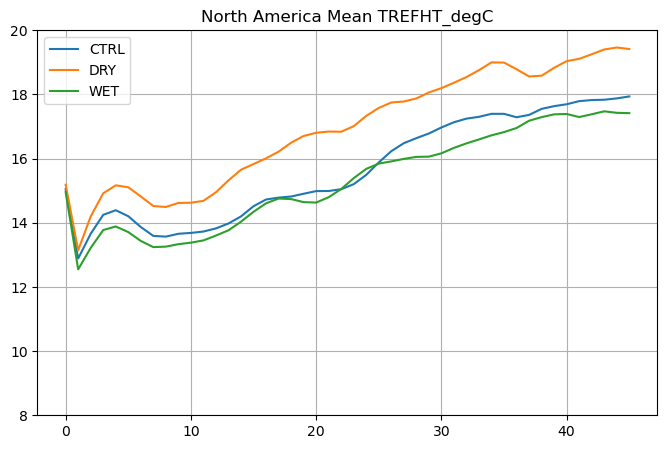

In [11]:
axs = plot_NAm_timeseries(atmDS_ctrl_ensMean, atmDS_dry_ensMean, atmDS_wet_ensMean, 'TREFHT_degC')
axs.set_ylim(8,20)

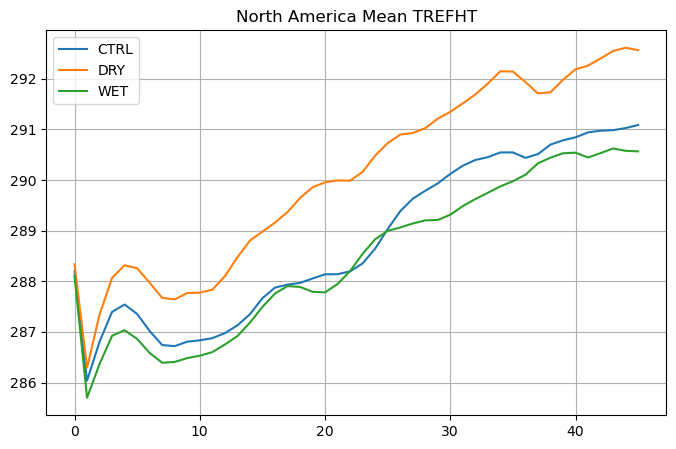

In [12]:
axs = plot_NAm_timeseries(atmDS_ctrl_ensMean, atmDS_dry_ensMean, atmDS_wet_ensMean, 'TREFHT')


Text(0, 0.5, 'kg/m2')

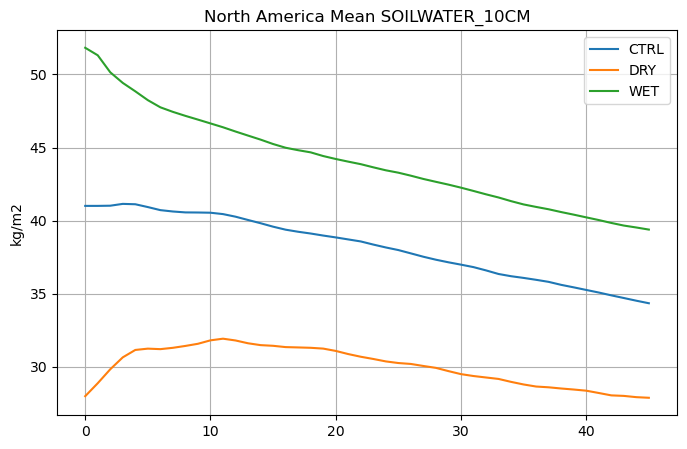

In [15]:
axs = plot_NAm_timeseries(lndDS_ctrl_ensMean, lndDS_dry_ensMean, lndDS_wet_ensMean, 'SOILWATER_10CM')
axs.set_ylabel('kg/m2')

<Axes: title={'center': 'North America Mean LHFLX'}>

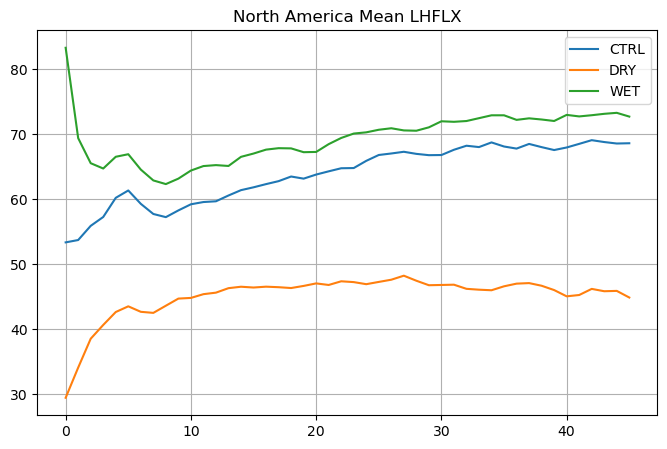

In [16]:
plot_NAm_timeseries(atmDS_ctrl_ensMean, atmDS_dry_ensMean, atmDS_wet_ensMean, 'LHFLX')

<Axes: title={'center': 'North America Mean SHFLX'}>

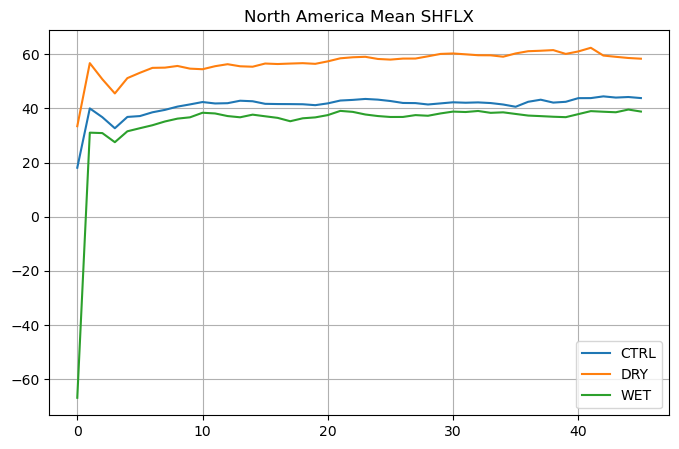

In [17]:
plot_NAm_timeseries(atmDS_ctrl_ensMean, atmDS_dry_ensMean, atmDS_wet_ensMean, 'SHFLX')

<Axes: title={'center': 'North America Mean PRECT_mmd'}>

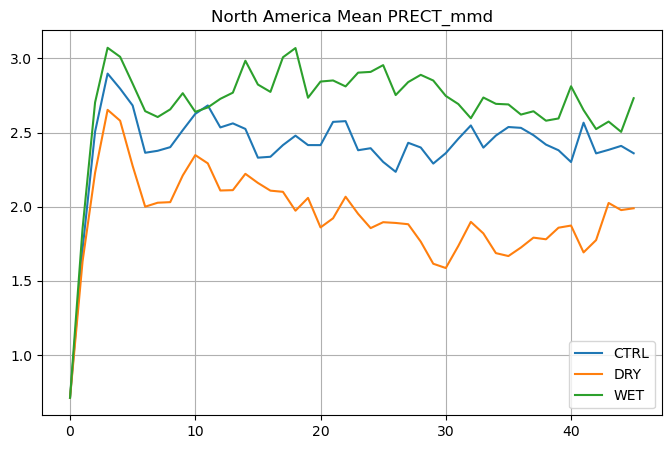

In [108]:
plot_NAm_timeseries(atmDS_ctrl_ensMean, atmDS_dry_ensMean, atmDS_wet_ensMean, 'PRECT_mmd')

In [11]:
## Global land temperature 
landT_ctrl = landMask* atmDS_ctrl_ensMean.TREFHT
landT_dry  = landMask* atmDS_dry_ensMean.TREFHT
landT_wet  = landMask* atmDS_wet_ensMean.TREFHT

coswgt   = np.cos(np.deg2rad(atmDS_ctrl_ensMean.lat))
    
landT_ctrl_mean   = landT_ctrl.weighted(coswgt).mean(('lon','lat'))
landT_dry_mean    = landT_dry.weighted(coswgt).mean(('lon','lat'))
landT_wet_mean    = landT_wet.weighted(coswgt).mean(('lon','lat'))

In [105]:
## Narrow in on N America? 
landT_ctrl_NAm = (landMask* atmDS_ctrl_ensMean.TREFHT).sel(lat=slice(10,90), lon=slice(185,310))
landT_dry_NAm  = (landMask* atmDS_dry_ensMean.TREFHT).sel(lat=slice(10,90), lon=slice(185,310))
landT_wet_NAm  = (landMask* atmDS_wet_ensMean.TREFHT).sel(lat=slice(10,90), lon=slice(185,310))

landT_ctrl_NAm_mean   = landT_ctrl_NAm.weighted(coswgt).mean(('lon','lat'))
landT_dry_NAm_mean    = landT_dry_NAm.weighted(coswgt).mean(('lon','lat'))
landT_wet_NAm_mean    = landT_wet_NAm.weighted(coswgt).mean(('lon','lat'))


Text(0.5, 1.0, 'Global Mean Land Temperature (2m)')

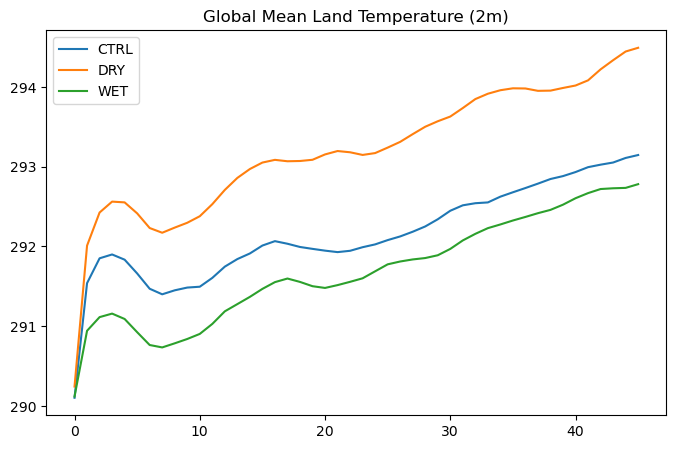

In [92]:
fig,axs = plt.subplots(1,1, figsize=(8,5))
axs.plot(landT_ctrl_mean, label='CTRL')
axs.plot(landT_dry_mean, label='DRY')
axs.plot(landT_wet_mean, label='WET')
axs.legend()
axs.set_title('Global Mean Land Temperature (2m)')


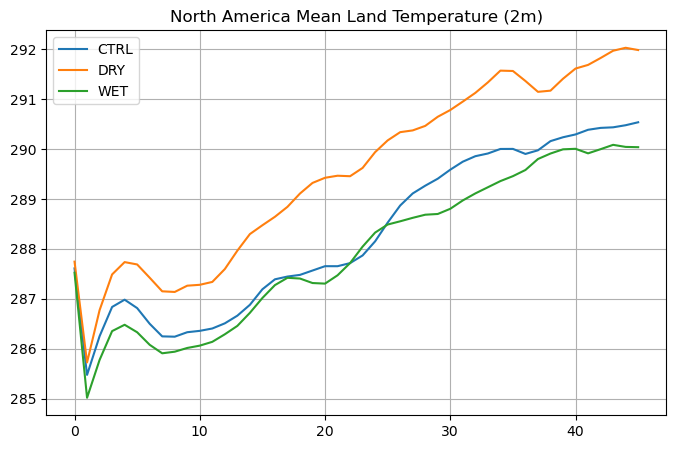

In [107]:
fig,axs = plt.subplots(1,1, figsize=(8,5))
axs.plot(landT_ctrl_NAm_mean, label='CTRL')
axs.plot(landT_dry_NAm_mean, label='DRY')
axs.plot(landT_wet_NAm_mean, label='WET')
axs.legend()
axs.set_title('North America Mean Land Temperature (2m)')

axs.grid()


## What's this like in context of climatology? 

In [109]:
def process_lnd(DS):
    keepVars = ['SOILWATER_10CM','RAIN']

    # Select just the initial condition (day 0)
    DS = DS.isel(time=0)
    
    # Select just the specified variable 
    DSproc = DS[keepVars]
    
    return DSproc

In [110]:
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/lnd/'

for iEns in range(11):
    if iEns<10: 
        listFiles = np.sort(glob.glob(dataDir+'*.0'+str(iEns)+'.clm2.h0.????-06-??-*.nc'))
    else: 
        listFiles = np.sort(glob.glob(dataDir+'*.'+str(iEns)+'.clm2.h0.????-06-??-*.nc'))

    DS_lnd_ens = xr.open_mfdataset(listFiles, preprocess=process_lnd, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    
    DS_lnd_ens = DS_lnd_ens.assign_coords({"ens":  iEns})

    if iEns==0:
        hindcast_DS = DS_lnd_ens
    else: 
        hindcast_DS = xr.concat([hindcast_DS, DS_lnd_ens], "ens") 

    print('Done with ens member ', iEns)
    

0
Done with ens member  0
1
Done with ens member  1
2
Done with ens member  2
3
Done with ens member  3
4
Done with ens member  4
5
Done with ens member  5
6
Done with ens member  6
7
Done with ens member  7
8
Done with ens member  8
9
Done with ens member  9
10
Done with ens member  10


In [111]:
## Also get the full reforecast for June 1 2021 initialization 
listFiles_caseStudy = np.sort(glob.glob(dataDir+'*.clm2.h0.2021-06-01-*.nc'))

for iEns in range(len(listFiles_caseStudy)):
    ensMember = int(listFiles_caseStudy[iEns].split('.')[2])  

    DS = xr.open_dataset(listFiles_caseStudy[iEns])[['SOILWATER_10CM','RAIN']]
    DS = DS.assign_coords({"ens":  iEns})

    if iEns==0:
        caseStudy_reforecast = DS
    else:
        caseStudy_reforecast = xr.concat([caseStudy_reforecast, DS], "ens")


In [70]:
# np.sort(glob.glob(dataDir+'*.clm2.h0.2021-05-26-*.nc'))

In [112]:
## Also get the full reforecast for June 8 2021 initialization 
listFiles_caseStudy = np.sort(glob.glob(dataDir+'*.clm2.h0.2021-06-08-*.nc'))

for iEns in range(len(listFiles_caseStudy)):
    ensMember = int(listFiles_caseStudy[iEns].split('.')[2])  

    DS = xr.open_dataset(listFiles_caseStudy[iEns])[['SOILWATER_10CM','RAIN']]
    DS = DS.assign_coords({"ens":  iEns})

    if iEns==0:
        caseStudy_reforecast2 = DS
    else:
        caseStudy_reforecast2 = xr.concat([caseStudy_reforecast2, DS], "ens")


In [113]:
## Also get the full reforecast for June 1 2021 initialization 
listFiles_caseStudy = np.sort(glob.glob(dataDir+'*.clm2.h0.2021-05-26-*.nc'))

for iEns in range(len(listFiles_caseStudy)):
    ensMember = int(listFiles_caseStudy[iEns].split('.')[2])  

    DS = xr.open_dataset(listFiles_caseStudy[iEns])[['SOILWATER_10CM','RAIN']]
    DS = DS.assign_coords({"ens":  iEns})

    if iEns==0:
        caseStudy_reforecast3 = DS
    else:
        caseStudy_reforecast3 = xr.concat([caseStudy_reforecast3, DS], "ens")


In [116]:
# Select North America 
hindcast_NAm = hindcast_DS.sel(lon=slice(220,310), lat=slice(5,75))
caseStudy_reforecast_NAm = caseStudy_reforecast.sel(lon=slice(220,310), lat=slice(5,75))


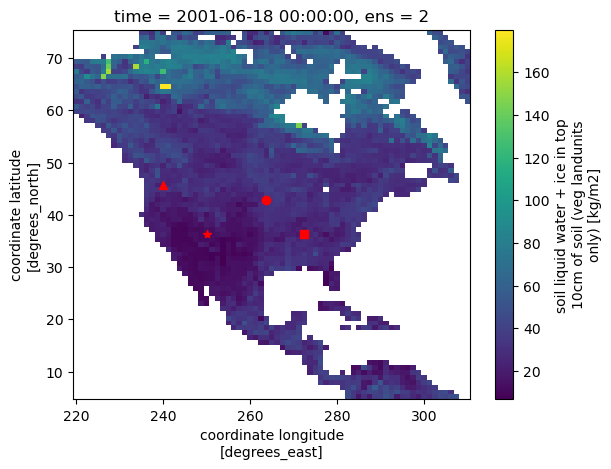

In [22]:
hindcast_NAm.isel(ens=2, time=10).SOILWATER_10CM.plot()
plt.plot(hindcast_NAm.lon.values[35], hindcast_NAm.lat.values[40], 'ro')
plt.plot(hindcast_NAm.lon.values[42], hindcast_NAm.lat.values[33], 'rs')
plt.plot(hindcast_NAm.lon.values[24], hindcast_NAm.lat.values[33], 'r*')
plt.plot(hindcast_NAm.lon.values[16], hindcast_NAm.lat.values[43], 'r^')


In [117]:
# Select North America 
lndDS_ctrl_NAm = lndDS_ctrl.sel(lon=slice(220,310), lat=slice(5,75))
lndDS_dry_NAm  = lndDS_dry.sel(lon=slice(220,310), lat=slice(5,75))
lndDS_wet_NAm  = lndDS_wet.sel(lon=slice(220,310), lat=slice(5,75))



/glade/derecho/scratch/mdfowler/tmp/ipykernel_64049/2016953577.py:21: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  axs.plot(hindcast_NAm.indexes['time'].to_datetimeindex(),


Text(0, 0.5, 'kg/m2')

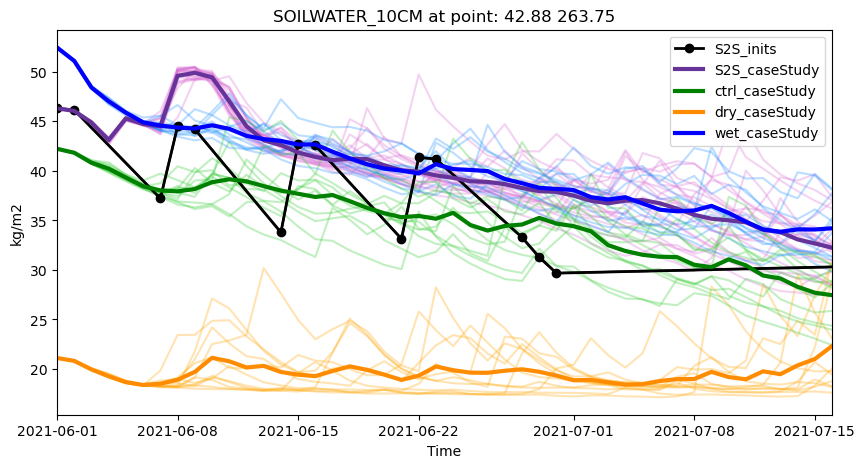

In [28]:
fig,axs = plt.subplots(1,1,figsize=(10,5))

# circle point
isel_lat = 40
isel_lon = 35

# # Square point
# isel_lat = 33
# isel_lon = 42

#Star Point
# isel_lat = 33
# isel_lon = 24

# # Triangle point
# isel_lat = 43
# isel_lon = 16


for iEns in range(len(hindcast_NAm.ens.values)):
    axs.plot(hindcast_NAm.indexes['time'].to_datetimeindex(), 
             hindcast_NAm.SOILWATER_10CM.isel(ens=iEns, lat=isel_lat, lon=isel_lon), color='grey', alpha=0.3) 

for iEns in range(len(caseStudy_reforecast_NAm.ens.values)):
    axs.plot(caseStudy_reforecast_NAm.time.values, 
             caseStudy_reforecast_NAm.isel(ens=iEns, lat=isel_lat, lon=isel_lon), color='orchid', alpha=0.3) 
   

for iEns in range(len(lndDS_ctrl.ens.values)):
    axs.plot(lndDS_ctrl_NAm.time.values, 
             lndDS_ctrl_NAm.SOILWATER_10CM.isel(ens=iEns, lat=isel_lat, lon=isel_lon), color='limegreen', alpha=0.3) 

    axs.plot(lndDS_dry_NAm.time.values,
             lndDS_dry_NAm.SOILWATER_10CM.isel(ens=iEns, lat=isel_lat, lon=isel_lon), color='orange', alpha=0.3) 
    
    axs.plot(lndDS_wet_NAm.time.values,
             lndDS_wet_NAm.SOILWATER_10CM.isel(ens=iEns, lat=isel_lat, lon=isel_lon), color='dodgerblue', alpha=0.3) 

## Plot the means
axs.plot(hindcast_NAm.time.values, 
         hindcast_NAm.SOILWATER_10CM.isel(lat=isel_lat, lon=isel_lon).mean(dim='ens'), 
         'o-', color='k',linewidth=2, label='S2S_inits') 

axs.plot(caseStudy_reforecast_NAm.time.values, 
         caseStudy_reforecast_NAm.isel(lat=isel_lat, lon=isel_lon).mean(dim='ens'), 
         '-', color='rebeccapurple',linewidth=3, label='S2S_caseStudy') 

axs.plot(lndDS_ctrl_NAm.time.values, 
         lndDS_ctrl_NAm.SOILWATER_10CM.isel(lat=isel_lat, lon=isel_lon).mean(dim='ens'), 
         color='green',linewidth=3, label='ctrl_caseStudy') 
axs.plot(lndDS_dry_NAm.time.values, 
         lndDS_dry_NAm.SOILWATER_10CM.isel(lat=isel_lat, lon=isel_lon).mean(dim='ens'), 
         color='darkorange',linewidth=3, label='dry_caseStudy') 
axs.plot(lndDS_wet_NAm.time.values, 
         lndDS_wet_NAm.SOILWATER_10CM.isel(lat=isel_lat, lon=isel_lon).mean(dim='ens'), 
         color='blue',linewidth=3, label='wet_caseStudy') 

axs.set_xlim([lndDS_ctrl_NAm.time.values[0], lndDS_ctrl_NAm.time.values[-1]])
axs.set_title('SOILWATER_10CM at point: '+ f"{lndDS_wet_NAm.lat.isel(lat=isel_lat).values:.2f}"+' '+f"{lndDS_wet_NAm.lon.isel(lon=isel_lon).values:.2f}" ) 
axs.legend()
axs.set_xlabel('Time')
axs.set_ylabel(lndDS_wet_NAm.SOILWATER_10CM.units)


In [71]:
# North America mean

# lndDS_ctrl_NAm = lndDS_ctrl.sel(lon=slice(220,310), lat=slice(5,75))
# lndDS_dry_NAm  = lndDS_dry.sel(lon=slice(220,310), lat=slice(5,75))
# lndDS_wet_NAm  = lndDS_wet.sel(lon=slice(220,310), lat=slice(5,75))

varSel = 'SOILWATER_10CM'

ctrl_NAm = (landMask* lndDS_ctrl[varSel]).sel(lat=slice(10,75), lon=slice(187.5,312.5))
dry_NAm  = (landMask* lndDS_dry[varSel]).sel(lat=slice(10,75), lon=slice(187.5,312.5))
wet_NAm  = (landMask* lndDS_wet[varSel]).sel(lat=slice(10,75), lon=slice(187.5,312.5))
reforecast_NAm = (landMask* caseStudy_reforecast).sel(lat=slice(10,75), lon=slice(187.5,312.5))
reforecast2_NAm = (landMask* caseStudy_reforecast2).sel(lat=slice(10,75), lon=slice(187.5,312.5))
reforecast3_NAm = (landMask* caseStudy_reforecast3).sel(lat=slice(10,75), lon=slice(187.5,312.5))

coswgt   = np.cos(np.deg2rad(lndDS_ctrl.lat))

ctrl_NAm_mean   = ctrl_NAm.weighted(coswgt).mean(('lon','lat'))
dry_NAm_mean    = dry_NAm.weighted(coswgt).mean(('lon','lat'))
wet_NAm_mean    = wet_NAm.weighted(coswgt).mean(('lon','lat'))
reforecast_NAm_mean = reforecast_NAm.weighted(coswgt).mean(('lon','lat'))
reforecast2_NAm_mean = reforecast2_NAm.weighted(coswgt).mean(('lon','lat'))
reforecast3_NAm_mean = reforecast3_NAm.weighted(coswgt).mean(('lon','lat'))



/glade/derecho/scratch/mdfowler/tmp/ipykernel_64049/1349112606.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  axs.plot(caseStudy_reforecast.indexes['time'].to_datetimeindex(),
/glade/derecho/scratch/mdfowler/tmp/ipykernel_64049/1349112606.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  axs.plot(caseStudy_reforecast2.indexes['time'].to_datetimeindex(),
/glade/derecho/scratch/mdfowler/tmp/ipykernel_64049/1349112606.py:13: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates f

Text(0, 0.5, 'kg/m2')

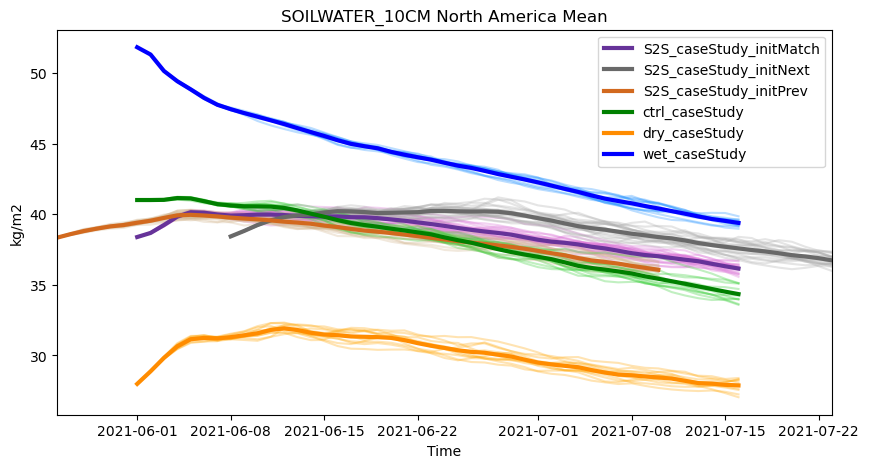

In [77]:
fig,axs = plt.subplots(1,1,figsize=(10,5))


for iEns in range(len(caseStudy_reforecast.ens.values)):
    axs.plot(caseStudy_reforecast.indexes['time'].to_datetimeindex(), 
             reforecast_NAm_mean.isel(ens=iEns), color='orchid', alpha=0.3) 

for iEns in range(len(caseStudy_reforecast2.ens.values)):
    axs.plot(caseStudy_reforecast2.indexes['time'].to_datetimeindex(), 
             reforecast2_NAm_mean.isel(ens=iEns), color='darkgray', alpha=0.3) 

for iEns in range(len(caseStudy_reforecast3.ens.values)):
    axs.plot(caseStudy_reforecast3.indexes['time'].to_datetimeindex(), 
             reforecast3_NAm_mean.isel(ens=iEns), color='tan', alpha=0.3) 


for iEns in range(len(ctrl_NAm_mean.ens.values)):
    axs.plot(ctrl_NAm_mean.time.values, 
             ctrl_NAm_mean.isel(ens=iEns), color='limegreen', alpha=0.3) 

    axs.plot(dry_NAm_mean.time.values,
             dry_NAm_mean.isel(ens=iEns), color='orange', alpha=0.3) 
    
    axs.plot(wet_NAm_mean.time.values,
             wet_NAm_mean.isel(ens=iEns), color='dodgerblue', alpha=0.3) 

## Plot the means

axs.plot(caseStudy_reforecast.indexes['time'].to_datetimeindex(), 
         reforecast_NAm_mean.mean(dim='ens'), 
         '-', color='rebeccapurple',linewidth=3, label='S2S_caseStudy_initMatch') 

axs.plot(caseStudy_reforecast2.indexes['time'].to_datetimeindex(), 
         reforecast2_NAm_mean.mean(dim='ens'), 
         '-', color='dimgray',linewidth=3, label='S2S_caseStudy_initNext') 
axs.plot(caseStudy_reforecast3.indexes['time'].to_datetimeindex(), 
         reforecast3_NAm_mean.mean(dim='ens'), 
         '-', color='chocolate',linewidth=3, label='S2S_caseStudy_initPrev') 


axs.plot(ctrl_NAm_mean.time.values, 
         ctrl_NAm_mean.mean(dim='ens'), 
         color='green',linewidth=3, label='ctrl_caseStudy') 
axs.plot(dry_NAm_mean.time.values, 
         dry_NAm_mean.mean(dim='ens'), 
         color='darkorange',linewidth=3, label='dry_caseStudy') 
axs.plot(wet_NAm_mean.time.values, 
         wet_NAm_mean.mean(dim='ens'), 
         color='blue',linewidth=3, label='wet_caseStudy') 

axs.set_xlim([caseStudy_reforecast3.indexes['time'].to_datetimeindex().values[0], 
              caseStudy_reforecast2.indexes['time'].to_datetimeindex().values[-1]])
axs.set_title('SOILWATER_10CM North America Mean' ) 
axs.legend()
axs.set_xlabel('Time')
axs.set_ylabel(lndDS_wet_NAm.SOILWATER_10CM.units)


In [118]:
# North America mean

# lndDS_ctrl_NAm = lndDS_ctrl.sel(lon=slice(220,310), lat=slice(5,75))
# lndDS_dry_NAm  = lndDS_dry.sel(lon=slice(220,310), lat=slice(5,75))
# lndDS_wet_NAm  = lndDS_wet.sel(lon=slice(220,310), lat=slice(5,75))

varSel = 'RAIN'

ctrl_NAm = (landMask* lndDS_ctrl[varSel]).sel(lat=slice(10,75), lon=slice(187.5,312.5))
dry_NAm  = (landMask* lndDS_dry[varSel]).sel(lat=slice(10,75), lon=slice(187.5,312.5))
wet_NAm  = (landMask* lndDS_wet[varSel]).sel(lat=slice(10,75), lon=slice(187.5,312.5))
reforecast_NAm = (landMask* caseStudy_reforecast).sel(lat=slice(10,75), lon=slice(187.5,312.5))
reforecast2_NAm = (landMask* caseStudy_reforecast2).sel(lat=slice(10,75), lon=slice(187.5,312.5))
reforecast3_NAm = (landMask* caseStudy_reforecast3).sel(lat=slice(10,75), lon=slice(187.5,312.5))

coswgt   = np.cos(np.deg2rad(lndDS_ctrl.lat))

ctrl_NAm_mean   = ctrl_NAm.weighted(coswgt).mean(('lon','lat'))
dry_NAm_mean    = dry_NAm.weighted(coswgt).mean(('lon','lat'))
wet_NAm_mean    = wet_NAm.weighted(coswgt).mean(('lon','lat'))
reforecast_NAm_mean = reforecast_NAm.weighted(coswgt).mean(('lon','lat'))
reforecast2_NAm_mean = reforecast2_NAm.weighted(coswgt).mean(('lon','lat'))
reforecast3_NAm_mean = reforecast3_NAm.weighted(coswgt).mean(('lon','lat'))



KeyError: "No variable named 'RAIN'. Variables on the dataset include ['SOILWATER_10CM', 'time', 'lon', 'lat', 'ens']"

## What about more climatologically? 

In [4]:
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/lnd/'

listFiles = np.sort(glob.glob(dataDir+'*.clm2.h0.????-06-0?-*.nc'))


In [28]:
## Get unique reforecasts 
for iFile in range(len(listFiles)):
    dateString = listFiles[iFile].split('.')[-2]
    if iFile==0:
        uniqDates = dateString
    else: 
        if dateString not in uniqDates:
            uniqDates = np.append(uniqDates, dateString)

## Read in each reforecast 
# for iTime in range(len(uniqDates)):
for iTime in range(2):
    listFiles_case = np.sort(glob.glob(dataDir+'*.clm2.h0.'+uniqDates[iTime]+'*.nc'))
    
    for iEns in range(len(listFiles_case)):
        # ensMember = int(listFiles_case[iEns].split('.')[2])  
        ensMember = int(listFiles_case[iEns].split('.clm2')[0].split('.')[-1])  
    
        DS = xr.open_dataset(listFiles_case[iEns])['SOILWATER_10CM']
        DS = DS.assign_coords({"ens":  iEns})

        ## Get North America mean
        DS_NAm      = (landMask* lndDS_ctrl['SOILWATER_10CM']).sel(lat=slice(10,75), lon=slice(187.5,312.5))
        coswgt      = np.cos(np.deg2rad(DS_NAm.lat))
        DS_NAm_mean = DS_NAm.weighted(coswgt).mean(('lon','lat'))
    
        if iEns==0:
            caseStudy = DS_NAm_mean
        else:
            caseStudy = xr.concat([DS_NAm_mean, DS], "ens")

    ## Change the time format
    lead_time = np.arange(46)
    init_date = caseStudy.time.values[0]
    
    ds_copy = caseStudy.copy()
    ds_copy = ds_copy.rename({'time': 'leadTime'})
    ds_copy = ds_copy.assign_coords(leadTime=lead_time)
    ds_copy = ds_copy.expand_dims(initDate=[init_date])
    del caseStudy,listFiles_case
    
    
    # # Get ens mean: 
    # ensMean = caseStudy.mean(dim='ens')
    

    if iTime==0:
        all_ensMean = ds_copy
    else: 
        all_ensMean = xr.concat([all_ensMean, ds_copy], "initDate")

    # print('Done with reforecast %i of %i ' % (iTime+1, len(uniqDates)))


ValueError: conflicting sizes for dimension 'leadTime': length 92 on <this-array> and length 46 on {'ens': 'ens', 'lon': 'lon', 'lat': 'lat', 'leadTime': 'leadTime'}

In [26]:
ds_copy

<xarray.DataArray 'SOILWATER_10CM' (ens: 12, leadTime: 92, lat: 192, lon: 288)> Size: 488MB
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]])
Coordinates:
  * leadTime  (leadTime) object 736B 1999-06-07 00:00:00 ... 2021-07-16 00:00:00
  * ens       (ens) int64 96B 0 1 2 3 4 5 6 7 8 9 10 10
  * lon       (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0

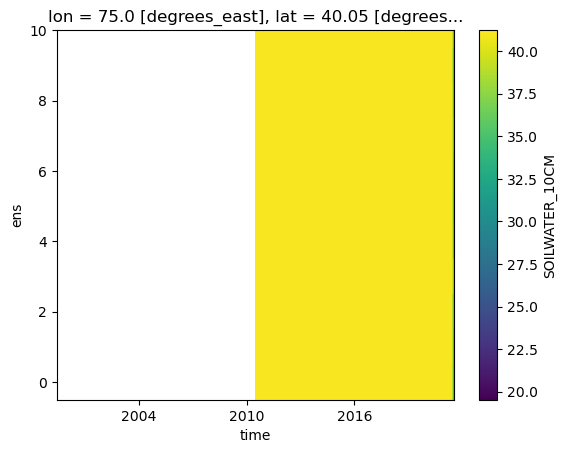

In [16]:
caseStudy.sel(lat=40,lon=75,method='nearest').plot()